## Part 2: Solving for MNL parameters in Julia

Max Kapur | <a href="https://www.maxkapur.com/">maxkapur.com</a>

Given schools' cutoffs, which are percentile values indicating the worst student they will accept, and schools' capacities, as estimated from past enrollment, we try to determine the underlying MNL parameters $\delta_c$ that produce such a market at equilibrium. We assume that the total number of students in the market equals the total demand, or number of enrollees at all the schools.

Since some schools have strongly negative preferability, I work with $\gamma_c \equiv \exp \delta_c$ instead of $\delta_c$. $\gamma_c=0$ is equivalent to $\delta_c \to-\infty$.

I use the JuMP Julia interface to the Ipopt nonlinear programming solver.

In [36]:
using DataFrames
using CSV
using JuMP
using Ipopt
using Plots
using Statistics

Read in the preprocessed data and peek at which universities were most and least selective.

In [23]:
stats = DataFrame(CSV.File("admitstats.csv"))

# Sort by cutoff to make admissions sets nested
sort!(stats, :cutoff)

# Delete a bunch of schools to make the problem more tractable.
# You can comment this out if you have time and lots of RAM.
delete!(stats, filter(x->x % 12 != 0, 1:size(stats)[1]))

# See discussion below
stats[!, :trueyield] = stats[!, :demand] ./ ((1 .- stats[!, :cutoff]) .* total_students)  

demand = stats[!, :demand]
cutoff = stats[!, :cutoff]
display(first(stats, 5))
display(last(stats, 5))
println("Total number of schools: $(size(stats)[1])")

,name,demand,cutoff,trueyield
,String,Int64,Float64,Float64
1,Saint Augustine's University,327,0.02,0.00347237
2,Pennsylvania State University-Penn State Schuylkill,248,0.03,0.00266063
3,Nyack College,264,0.04,0.00286178
4,University of Pikeville,386,0.05,0.00422832
5,Texas Southern University,1110,0.05,0.0121591


,name,demand,cutoff,trueyield
,String,Int64,Float64,Float64
1,University of Wisconsin-Madison,6279,0.81,0.343907
2,University of Rochester,1472,0.86,0.109417
3,Claremont McKenna College,337,0.88,0.0292249
4,Pomona College,397,0.91,0.0459041
5,Princeton University,1285,0.94,0.222872


Total number of schools: 98


Plot the cutoffs. Looks like we have an interesting, skewed distribution: a few very selective schools and a lot with looser admissions standards.

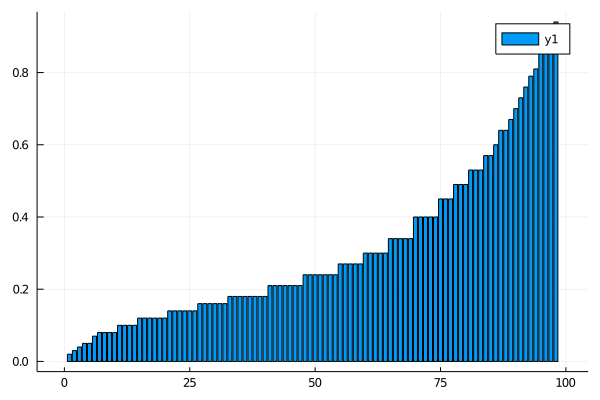

In [82]:
plot(stats[!, :cutoff], st=:bar)

Do the optimization. The demand for each school is a function of the preferability parameters and the total population, and the value of this function at each school must match the demand indicated in the input data.

In [9]:
function optimize()
    (m, ) = size(cutoff)
    p = vcat(cutoff, 1)

    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "hessian_approximation", "limited-memory")

    @variable(model, γ[1:m], lower_bound=0, upper_bound=1)
    total_pop = sum(demand)

    # Demand for each school must equal that predicted by MNL model.
    @NLconstraint(model, Demand[c in 1:m], 
                    total_pop * γ[c] * sum((p[d+1] - p[d]) / sum(γ[i] for i in 1:d) for d in c:m)
                    == demand[c])
    
    optimize!(model)
    
#     δ = log.(value.(γ))
    
    return value.(γ)
end

optimize (generic function with 1 method)

In [10]:
γ = optimize()

98-element Vector{Float64}:
 1.1163367874903372e-8
 0.0
 0.0
 5.7510942998086474e-9
 1.6615368843399836e-9
 1.8105599623364777e-8
 0.0
 0.0
 1.241328354575409e-8
 6.421173618717764e-9
 0.0
 0.0
 0.0
 ⋮
 0.0028932978018452625
 0.02923611001270366
 0.2687523951127562
 0.03229894047663324
 0.2859650483915003
 0.060294158588455646
 0.18186547499421013
 0.9861020820476553
 0.3382664412158383
 0.0886532173524056
 0.14868828423350233
 0.817671421613194

In [26]:
stats[!, :preferability] = γ;

Plot the preferability against cutoffs and capacities and see if there are any outliers.

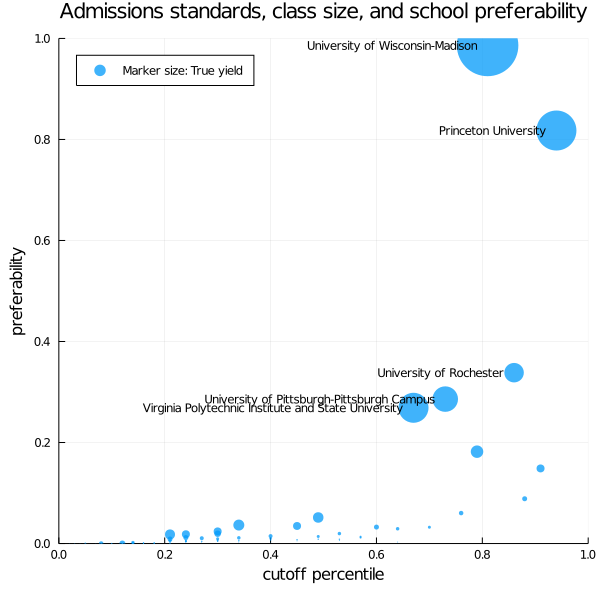

In [83]:
pl = plot(size=(600, 600), xlim=(0, 1), ylim=(0, 1),
          xlabel="cutoff percentile", ylabel="preferability", legend=:topleft,
          title="Admissions standards, class size, and school preferability")

scatter!(pl,
         stats[!, :cutoff],
         stats[!, :preferability],
         marker=:circle,
         ms=stats[!, :trueyield]*100,
         msw=0,
         ma=.75,
         label="Marker size: True yield")

best = sortperm(stats[!, :preferability], rev=true)

for i in 1:5
    annotate!(pl,
          [(stats[best[i], :cutoff] - .02, 
            stats[best[i], :preferability],
            text(stats[best[i], :name], :right, 8))])
end

pl

## Discussion

What do you think? Does it look realistic? 

In general, the schools that top the list are popular overall. But it's surprising to see that, for example, UW Madison has a higher preferability rating than Princeton, which means (by the definition of the preference parameters) that a student admitted to both schools is slighly more likely to choose UW Madison.

This is an artifact of the design of the model, which considers only SAT math scores. UW Madison has unusually high math scores. Perhaps this is because most UW Madison applicants take the ACT (which is more popular in the Midwest) rather than the SAT; hence, the subset of admits who submitted the SAT are out-of-state students who are atypically zealous about their college search.

But for the sake of argument, let's take the results at face value and try to understand the economic relationship between cutoffs, demand, and what I am calling "true yield." In the model, Princeton's cutoff is 0.94, which means 6 percent or 5766 of the 96094 students in the market are able to get into Princeton. The number who chose to attend is 1285, for a true yield of 22 percent. 

On the other hand, UW Madison's cutoff is 0.81, so 19 percent of students can get into UW Madison, and of them 6279 choose to attend, for a true yield of 34 percent.

In [19]:
total_students = sum(demand)
1285 /                        # Number of students who attend Princeton
    (0.06 * total_students)   # Number of students who could get into Princeton

0.2228720488965666

In [21]:
6279 /                        # Number of students who attend UW Madison
    (0.19 * total_students)   # Number of students who could get into UW Madison

0.34390667909601674

The inevitable conclusion, according to these results, is that UW Madison is more preferable overall. Consider it this way: UW Madison enrolls five times as many students as Princeton. And every student who is qualified for Princeton is also qualified for UW Madison. So, if every student who got into both schools chose Princeton, then UW Madison would have to *admit* six times as many students as Princeton to achieve this level of enrollment. But in reality, UW Madison admits about three times as many students as Princeton. This can only be explained by the fact that some (in fact, a plurality of) students who get into both schools choose UW Madison—again, according to this very limited model, which greatly underestimates Princeton's score cutoff. 

### True yield

The phrase "true yield" appears in scare quotes above because I am using it with a somewhat special meaning. Admissions officials use "yield" to refer to the percentage of *admitted applicants* who choose to attend the school. This is a function of three variables: the school's cutoff, the school's preferability, and the percentage of students who choose to apply.

True yield is the percentage of *qualified students* who choose to attend the school, and it is a function of only the school's preferability and cutoff. In reality, some students who will not attend a given college because they are uninterested or unqualified remove themselves from the applicant pool altogether; this phenomenon artificially inflates yield.

The common misuse of yield in college rankings as an indication of preferability has given rise to urban legends about <a href="https://en.wikipedia.org/wiki/Yield_protection">yield protection</a>, the idea that some middling colleges reject highly-qualified applicants whom they expect to attend a better school to pad their yield statistics.

Notice that the best predictor of preferability is true yield, and vice-versa ($r = 0.95$).

In [50]:
cor(Array(stats[!, [:demand, :cutoff, :trueyield, :preferability]]))

4×4 Matrix{Float64}:
 1.0       0.278889  0.747818  0.512622
 0.278889  1.0       0.572067  0.577453
 0.747818  0.572067  1.0       0.949407
 0.512622  0.577453  0.949407  1.0

In [84]:
savefig(pl, "cutoffs_and_pref.png")
savefig(pl, "cutoffs_and_pref.pdf")